Note: with the direct mean calculation, the total contribution to the mean of all points will sum to 0 - meaning it is impossible to distribute the shap values among them and total anything other than 0
Solution 1: avoid negative contributions
Solution 2 (currently used): scale around mean, not 0 - so a point equal to the mean contributes "mean" times

In [136]:
import sys
import os
import pandas as pd
import pickle
import featuretools as ft
import matplotlib.pyplot as plt
import numpy as np

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from model.data import get_patient_records, load_pic

In [137]:
ROOT = os.path.abspath('../')
# PIC_dir = os.path.join(ROOT, 'data/raw/PIC/')
PIC_dir = os.path.join(ROOT, 'data/raw/PIC_mini/')
output_dir = os.path.join(ROOT, 'data/intermediate/')

In [138]:
def save_entityset(entityset):  # saves a serialized entity set in output_dir/entityset
    with open(os.path.join(output_dir, 'entityset'), 'wb') as f:
        pickle.dump(entityset, f)
        
def load_entityset(): # loads a serialized entiy set
    with open(os.path.join(output_dir, 'entityset'), 'rb') as f:
        return pickle.load(f)
    
def save_fm(df, fm_list, token=''):  # saves a fm_list both as a pickle and a csv
    if str(token) != '':
        token = '_' + str(token)
    with open(os.path.join(output_dir, 'fl{}.pkl'.format(token)), 'wb') as f:
        pickle.dump(fm_list, f)
    df.to_csv(os.path.join(output_dir, 'fm{}.csv'.format(token)))
    
def load_fm(token=None): # loads an fm_list both as an object and a DataFrame
    if str(token) != '':
        token = '_' + str(token)
    with open(os.path.join(output_dir, 'fl{}.pkl'.format(token)), 'rb') as f:
        fm_list = pickle.load(f)
    df = pd.read_csv(os.path.join(output_dir, 'fm{}.csv'.format(token)), index_col=0)
    return df, fm_list

In [139]:
es = load_pic()

Prune (0/1934) rows.
Prune (0/1996) rows.
Prune (0/2108) rows.
Prune (0/1838) rows.
Prune (0/3778) rows.
Prune (0/754213) rows.
Prune (0/75981) rows.
Prune (0/1724805) rows.
Prune (0/29547) rows.
Prune (0/39872) rows.
Prune (0/450989) rows.
Prune (253/2837) rows.
Prune (0/7849) rows.
Prune (0/171332) rows.
Prune (0/479) rows.
Prune (0/832) rows.
Prune (0/25379) rows.


In [140]:
df, fm_list = load_fm('signal_only')

In [152]:
model = pickle.load(open("model.pkl", "rb"))
X_train = pd.read_csv("train.csv", index_col=0)
X_test = pd.read_csv("test.csv", index_col=0)
transformers = pickle.load(open("transformers.pkl", "rb"))

In [142]:
# Helper functions for explanation

def get_record_id_from_name(record_name, feature_table_name):
    feature_rows = es["D_ITEMS"].df.loc[es["D_ITEMS"].df["LABEL"] == record_name]
    record_id = feature_rows.loc[feature_rows["LINKSTO"].str.lower() == feature_table_name.lower()]["ITEMID"][0]
    return record_id

def extract_signal(uni_oper_id, feature_table_name, record_id):
    full_table = es[feature_table_name].df
    oper_feature_table = full_table.loc[full_table["UNI_OPER_ID"] == uni_oper_id]

    feature_table = oper_feature_table.loc[oper_feature_table["ITEMID"] == record_id]
    feature_table.sort_values(by="MONITOR_TIME", axis="index", inplace=True)

    feature_signal = feature_table["VALUE"]

    return feature_signal

def visualize_signal(signal, c=None, vmin=None, vmax=None):
    plt.plot(np.arange(len(signal)), signal, c="black", zorder=1)
    plt.scatter(np.arange(len(signal)), signal, c=c, cmap="Reds_r", vmin=vmin, vmax=vmax, zorder=2)
    if c is not None:
        plt.colorbar()
        
def distribute_shap(shap_value, v):
    v_norm = v / sum(v)
    return shap_value * v_norm

In [143]:
# Helper functions to run occlusion algorithm

def occlude(signal, algorithm, start, size):
    # algorithm - one of:
    #    linear - linearly connect the window endpoints
    #    mean - fill with constant equal to window mean
    #    start - fill with constant equal to first endpoint
    #    mean_endpoints - fill with constant equal to mean of endpoints
    
    occluded = signal.copy()
    endpoint_1 = signal[start]
    if start+size-1 < len(signal):
        endpoint_2 =signal[start+size-1]
    else:
        endpoint_2 = signal[len(signal)-1]
        
    if algorithm == "linear":
        occluded[start:start+size] = np.linspace(endpoint_1, endpoint_2, len(occluded[start:start+size]))
        return occluded
            
    if algorithm == "mean":
        value = signal[start:start+size].mean()
        
    if algorithm == "start":
        value = signal[start]
        
    if algorithm == "mean_endpoints":
        value = (endpoint_1 + endpoint_2) / 2
    
    occluded[start:start+size] = value
    return occluded

def run_occlusion(signal, primitives, algorithm, window_size=5):
    base_values = []
    for primitive in primitives:
        base_values.append(primitive(signal))
    v = np.zeros((len(signal), len(primitives)))
    hits = np.zeros(len(signal))
    for start in range(len(signal)):
        occluded = occlude(signal, "linear", start, window_size)
        new_values = []
        for primitive in primitives:
            new_values.append(primitive(occluded))
        for i in range(len(base_values)):
            v[start:start+window_size, i] += ((base_values[i] - new_values[i]) / np.abs(base_values[i])) 
        hits[start:start+window_size] += 1

    v = v / hits.reshape(-1, 1)
    return v

def mean_contributions(signal):
    # Calculate the importance of each point to the mean
    mean = np.mean(signal)
    n = len(signal)
    new_means = np.array([(np.sum(signal) - x + mean) / n for x in signal])
    v = (-new_means) / (np.abs(mean))
    return v

In [144]:
def occlusion_explain(record_id, feature_table_name, primitive, primitive_name, uni_oper_id, 
                      algorithm="linear", window_size=5,
                      return_signal=False):
    signal = extract_signal(uni_oper_id, feature_table_name, record_id).to_numpy()
    
    if primitive_name == "MEAN_":
        v = mean_contributions(signal)
    else:
        v = run_occlusion(signal, [primitive], algorithm, window_size)
        
    if uni_oper_id in X_train.index:
        shap_values = explainer.shap_values(X_train.loc[[uni_oper_id]].to_numpy())[0]
    else:
        shap_values = explainer.shap_values(X_test.loc[[uni_oper_id]].to_numpy())[0]
    feature_name = "%s(%s.VALUE WHERE ITEMID = %s)" % (primitive_name, feature_table_name, record_id)
    feature_ind = X_train.columns.get_loc(feature_name)
    feature_shap_value = shap_values[feature_ind]
    
    weighted_contribution = distribute_shap(feature_shap_value, v)
    if return_signal:
        return weighted_contribution, signal
    return weighted_contribution

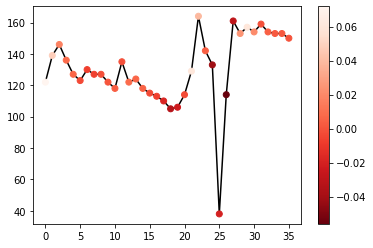

In [145]:
pulse_id = get_record_id_from_name("Pulse", "SURGERY_VITAL_SIGNS")
pulse_contributions, pulse_signal = occlusion_explain(pulse_id, "SURGERY_VITAL_SIGNS", ft.primitives.Mean(), 
                                                      "MEAN", 885705, return_signal=True)

visualize_signal(pulse_signal, c=pulse_contributions)

In [195]:
def transform(x):
    trans_x = x.copy()
    for transformer in transformers:
        trans_x = transformer.transform(trans_x)
    return trans_x

def run_occlusion_shap(signal, primitive, x, feature_name, algorithm, window_size=5):
    shap_values = explainer.shap_values(transform(x.to_numpy()))[0]
    feature_ind = x.columns.get_loc(feature_name)
    base_value = shap_values[feature_ind]
    
    v = np.zeros(len(signal))
    hits = np.zeros(len(signal))
    for start in range(len(signal)):
        occluded = occlude(signal, "linear", start, window_size)
        new_value = primitive(occluded)
        x_copy = x.copy()
        x_copy[feature_name] = new_value
        new_shap_value = explainer.shap_values(transform(x_copy.to_numpy()))[0][feature_ind]
        v[start:start+window_size] += ((base_value - new_shap_value) / np.abs(base_value)) 
        hits[start:start+window_size] += 1
    v = v / hits
    return v

def occlusion_explain_shap(record_id, feature_table_name, primitive, primitive_name, uni_oper_id, 
                           algorithm="linear", window_size=5,
                           return_signal=False):
    signal = extract_signal(uni_oper_id, feature_table_name, record_id).to_numpy()
    
    feature_name = "%s(%s.VALUE WHERE ITEMID = %s)" % (primitive_name, feature_table_name, record_id)
    if uni_oper_id in X_train.index:
        x = X_train.loc[[uni_oper_id]]
    else:
        x = X_test.loc[[uni_oper_id]]

    v = run_occlusion_shap(signal, primitive, x, feature_name, algorithm, window_size)
    if return_signal:
        return v, signal
    return v

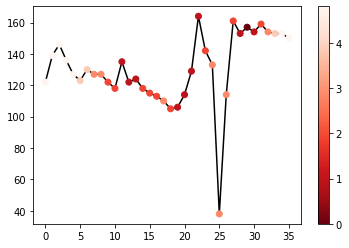

In [196]:
pulse_id = get_record_id_from_name("Pulse", "SURGERY_VITAL_SIGNS")
pulse_contributions, pulse_signal = occlusion_explain_shap(pulse_id, "SURGERY_VITAL_SIGNS", ft.primitives.Mean(), 
                                                           "MEAN", 885705, return_signal=True, window_size=5)

visualize_signal(pulse_signal, c=pulse_contributions)

In [135]:
es["SURGERY_VITAL_SIGNS"].df

,ROW_ID,SUBJECT_ID,HADM_ID,VISIT_ID,OPER_ID,ITEM_NO,MONITOR_TIME,ITEMID,VALUE,UNI_OPER_ID
1106602,1106602,9280,109451,1,1,1,2067-01-06 11:07:00,SV1,147.0,604873
1106603,1106603,9280,109451,1,1,1,2067-01-06 11:07:00,SV13,25.0,604873
1106604,1106604,9280,109451,1,1,1,2067-01-06 11:07:00,SV16,34.0,604873
1106605,1106605,9280,109451,1,1,1,2067-01-06 11:07:00,SV18,1.0,604873
1106611,1106611,9280,109451,1,1,2,2067-01-06 11:10:00,SV1,141.0,604873
...,...,...,...,...,...,...,...,...,...,...
479895,479895,13320,113839,1,1,46,2118-09-15 11:55:00,SV6,7.0,885705
479896,479896,13320,113839,1,1,46,2118-09-15 11:55:00,SV13,22.0,885705
479897,479897,13320,113839,1,1,46,2118-09-15 11:55:00,SV17,100.0,885705
479898,479898,13320,113839,1,1,46,2118-09-15 11:55:00,SV16,33.0,885705
